The goal of this notebook is to compare the effects of timestep size on simulation stability and accuracy. In this case we'll be using a simulation of the fish running on an open loop, sinusoidal policy. The simulation with timesteps of 0.001 seconds will serve as a baseline as it seems to demonstrate stable behavior.

In [1]:
# imports 
import sys
import os
import numpy as np
import psycopg2
import pickle
import logging
import dask.dataframe as dd
from sqlalchemy import create_engine
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from dotenv import dotenv_values


config = dotenv_values(".env")
  safd



Helper functions

In [2]:
def get_db_connection():
    conn = psycopg2.connect(
        dbname='simDB',
        user='user',
        password='password',
        host='localhost',
        port='5432'
    )
    return conn

def fetch_trial_data(conn, trial_id,n=1,limit=500):
    try:
        cur = conn.cursor()
        
        # Fetch data for the given trial_id
        query = '''
        SELECT timestep, simulation_time, input_data, output_data, state_data
        FROM simulation_data
        WHERE trial_id = %s AND MOD(timestep, %s) = 0
        ORDER BY timestep ASC LIMIT %s;
        '''
        cur.execute(query, (trial_id, n, limit))
        rows = cur.fetchall()
        
        # Deserialize data
        data = []
        for row in rows:
            timestep, simulation_time, input_data_bin, output_data_bin, state_data_bin = row
            input_data = pickle.loads(input_data_bin)
            output_data = pickle.loads(output_data_bin)
            state_data = pickle.loads(state_data_bin)
            data.append((timestep, simulation_time, input_data, output_data, state_data))
        
        cur.close()
        return data
    except Exception as e:
        print(f"Error fetching data for trial_id {trial_id}: {e}")
        return None

In [3]:
# Preallocate array for output data 
timesteps = 1000
outputDim = 40
trials = 1
outputs = np.zeros((outputDim,timesteps,trials))
times = np.zeros((timesteps,trials))


In [4]:
# Generate list of trial_ids and downsampling factors

# trial_ids = [21, 23, 25, 26]
# trial_ids = [27, 28, 29, 30]
# trial_ids = [27, 28, 29, 30]
# trial_ids = [35, 36, 37, 38]
# trial_ids = [39, 40, 41, 42]
# trial_ids = [43, 44, 45, 46]
# n_values = [10,5,2,1]

# trial_ids = [15, 25, 29, 33]


trial_ids = [89]
n_values = [1]

# trial_ids = [31,32,35,36]
# n_values = [10,5,10,5]

# trial_ids = [56,57,58,59]
# n_values = [10,5,2,1]


In [5]:
# Iterate over trials and fetch data
for i, trial_id in enumerate(trial_ids):
    print(f"Fetching data for trial_id {trial_id}")
    conn = get_db_connection()
    n = n_values[i]
    trial_data = fetch_trial_data(conn, trial_id,n,limit=timesteps)
    conn.close()
    
    # Extract output data
    for timestep, simulation_time, input_data, output_data, state_data in trial_data[:timesteps]:
        outputs[:,timestep//n,i] = output_data
        times[timestep//n,i] = simulation_time
# conn = get_db_connection()

# trial_id = 13  # Replace with the trial_id you want to fetch
# n = 100
# trial_data = fetch_trial_data(conn, trial_id,n)
# trial_data.type

# if trial_data:
#     for timestep, simulation_time, input_data, output_data, state_data in trial_data:
#         print(f"Timestep: {timestep}, Simulation Time: {simulation_time}")
#         print(f"Input Data: {input_data}")
#         print(f"Output Data: {output_data}")
#         print(f"State Data: {state_data}")

# conn.close()


Fetching data for trial_id 89


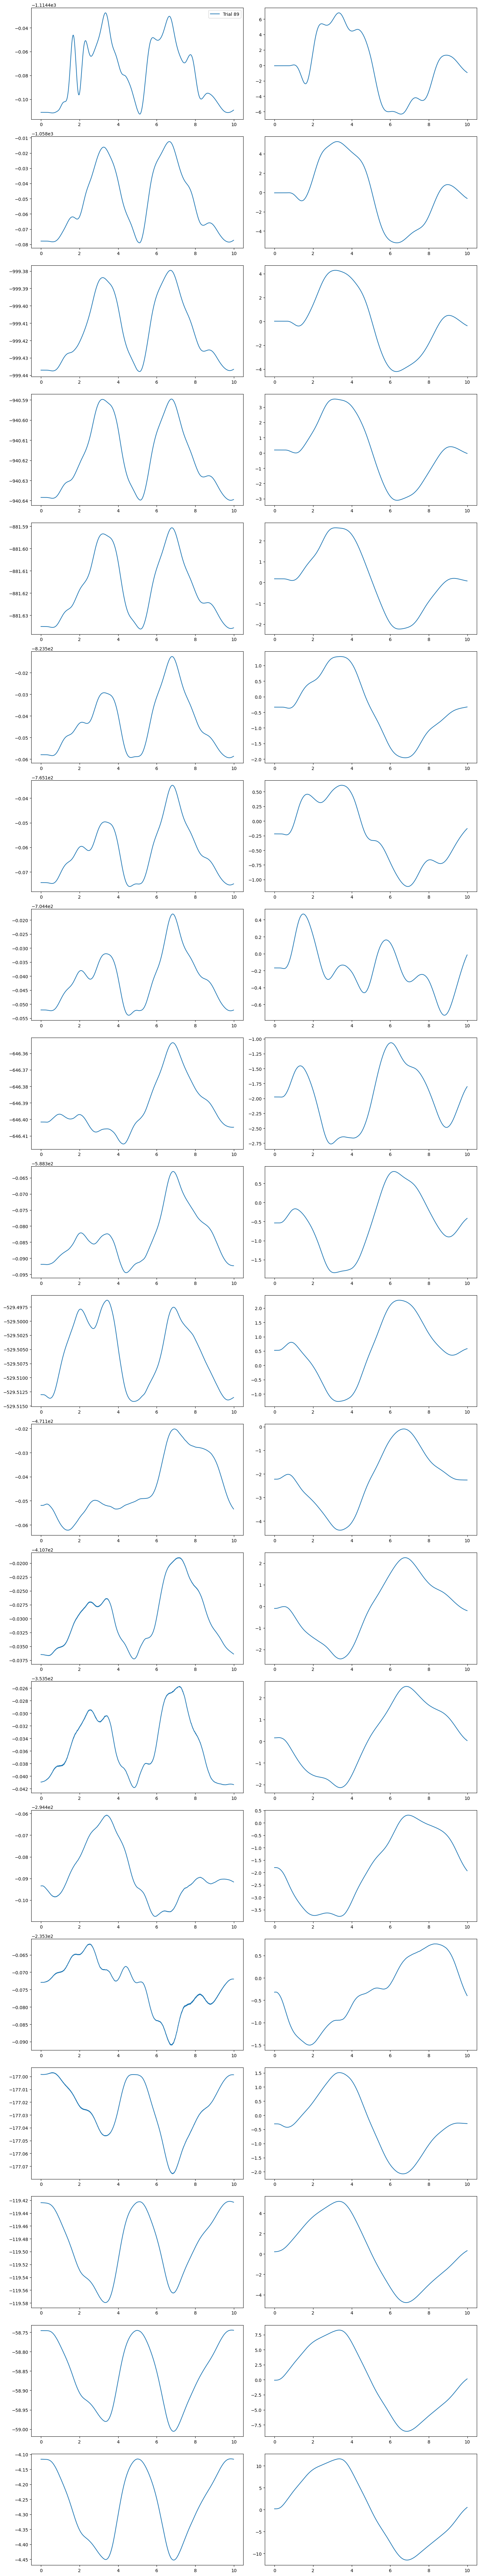

In [6]:
# Plot each output trajectories over time on 40 subplots with 2 columns of 20 rows, plotting trajectories from each trial in different colors
fig, axs = plt.subplots(20, 2, figsize=(15, 80))
for i in range(outputDim):
    for j in range(trials):
        axs[i//2, i%2].plot(times[:,j], outputs[i,:,j])

# Add legend to the first subplot
axs[0,0].legend([f'Trial {i}' for i in trial_ids])
plt.tight_layout()
plt.show()


# Animate the centerline trajectories over time


In [7]:
# Setup save path for videos
video_path = config["currentDirectory"] +"data/videos/timestepTestNewLowAmpFirst.mp4"
# Number of frames and playspeed for video
numFrames = 1000
fps = 100
duration = numFrames/fps


Moviepy - Building video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/videos/timestepTestNewLowAmpFirst.mp4.
Moviepy - Writing video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/videos/timestepTestNewLowAmpFirst.mp4



Moviepy - Done !
Moviepy - video ready /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/videos/timestepTestNewLowAmpFirst.mp4


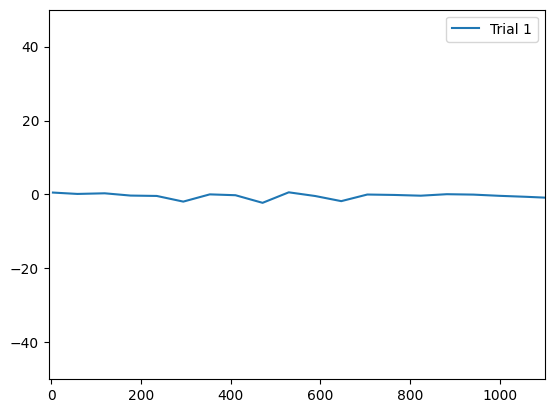

In [8]:
# Set up figure
fig, ax = plt.subplots()

# define animation callback
def animate(t):
    ax.clear()
    for j in range(trials):
        # Get frame index
        frame = int(round(t*fps))
        # Grab the output vector for the current timestep and trial
        output = outputs[:,frame,j]
        # Pack 40x1 output vector into 20x2 x-z pairs for plotting the centerline
        centerline = np.reshape(output, (20, 2))
        # Flip the sign of the x-values to plot the centerline in the correct orientation
        centerline[:,0] = -centerline[:,0]
        # Plot reduced centerline
        ax.plot(centerline[:,0], centerline[:,1], label=f'Trial {j+1}')
    ax.legend()
    ax.set_xlim(-5, 1100)
    ax.set_ylim(-50, 50)

    return mplfig_to_npimage(fig)

animation = VideoClip(animate, duration=duration)
animation.write_videofile(video_path, fps=fps)



In [9]:
lowAmp = 0.04
highAmp = 0.16
allAmplitudes = [[lowAmp,0,0],
				[0,lowAmp,0],
				[0,0,lowAmp],
				[lowAmp,lowAmp,lowAmp],
				[highAmp ,0,0],
				[0,highAmp,0],
				[0,0,highAmp],
				[highAmp,highAmp,highAmp],
				]
freqs = [0.1,0.3,0.5,1,1.5]


In [10]:
for amplitudes in allAmplitudes:
    print(amplitudes)

[0.04, 0, 0]
[0, 0.04, 0]
[0, 0, 0.04]
[0.04, 0.04, 0.04]
[0.16, 0, 0]
[0, 0.16, 0]
[0, 0, 0.16]
[0.16, 0.16, 0.16]
